# A simple example for machine learning with uproot / coffea

Let's try to distinguish DY from ttW with just using rather low level inputs, and then compare to a simple M(ll) based discriminator.

In [1]:
import uproot
import awkward
import numpy as np
import pandas as pd
from uproot_methods import TLorentzVectorArray

from coffea.processor import LazyDataFrame
from coffea.analysis_objects import JaggedCandidateArray

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import tensorflow as tf

In [2]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split

In [3]:

# Load some prepared data
sig_file = uproot.open('DY.root')
bkg_file = uproot.open('bkg.root')

bkg_tree = bkg_file['Events']
sig_tree = sig_file['Events']
bkg = LazyDataFrame(bkg_tree, flatten=True)
sig = LazyDataFrame(sig_tree, flatten=True)

print ("Have %s signal events and %s background events"%(len(sig['MET_phi']), len(bkg['MET_phi'])))


Have 63189 signal events and 392177 background events


In [4]:
## Preprocessing data. This is rather slow, so probably building a custom data frame or dictionary would make more sense
#sig_df_in = sig_tree.pandas.df(flatten=False)
#bkg_df_in = bkg_tree.pandas.df(flatten=False)


In [5]:
def convertToDF( df ):

    eventSelection = ( (df['nLepton']==2) & (df['nVetoLepton']==2) )
    #df = df[eventSelection]
    
    jets = JaggedCandidateArray.candidatesfromcounts(
        df['nJet'],
        pt=df['Jet_pt'],
        eta=df['Jet_eta'],
        phi=df['Jet_phi'],
        mass=df['Jet_mass'],
        btag=df['Jet_btagDeepB'],
    )
    
    leptons = JaggedCandidateArray.candidatesfromcounts(
        df['nLepton'],
        pt=df['Lepton_pt'],
        eta=df['Lepton_eta'],
        phi=df['Lepton_phi'],
        mass= df['Lepton_mass'],
        charge=df['Lepton_pdgId']/abs(df['Lepton_pdgId'])
    )

    leadingJet = jets[jets.pt.argmax()]
    leadingJet = leadingJet[eventSelection]
    
    leptons = leptons[eventSelection]
    
    leadingLepton = leptons[leptons.pt.argmax()]
    
    subleadingLepton = leptons[leptons.pt.argmin()] # this works because we select events with just two leptons in the end
    
    dileptons = leptons.choose(2)
    
    met = pd.DataFrame({'pt':df['MET_pt'], 'phi':df['MET_phi']}) # there should be a better way than this, but otherwise can't select events
    
    met = met[eventSelection]
    
    return pd.DataFrame({
            'leadingJet_pt':leadingJet.pt.flatten(), 
            'lep0_pt':dileptons.i0.pt.flatten(),
            'lep0_eta':dileptons.i0.eta.flatten(),
            'lep0_phi':dileptons.i0.phi.flatten(),
            'lep0_charge':dileptons.i0.charge.flatten(),
            'lep0_mass':dileptons.i0.mass.flatten(),
            'lep1_pt':dileptons.i1.pt.flatten(),
            'lep1_eta':dileptons.i1.eta.flatten(),
            'lep1_phi':dileptons.i1.phi.flatten(),
            'lep1_charge':dileptons.i1.charge.flatten(),
            'lep1_mass':dileptons.i1.mass.flatten(),
            'mll': dileptons.mass.flatten(), 
            'dilepton_pt':dileptons.pt.flatten(),
            'MET_pt':met['pt'],
    })




In [6]:
sig_df = convertToDF( sig )
bkg_df = convertToDF( bkg )

In [7]:
#sig = sig_df_in[((sig_df_in['nLepton']==2) & (sig_df_in['nVetoLepton']==2))]
#sig_df = pd.DataFrame({'MET_pt': sig['MET_pt'], 'nGoodJet': sig['nGoodJet']})

#bkg = bkg_df_in[((bkg_df_in['nLepton']==2) & (bkg_df_in['nVetoLepton']==2))]
#bkg_df = pd.DataFrame({'MET_pt': bkg['MET_pt'], 'nGoodJet': bkg['nGoodJet']})

#print (len(my_bkg_df['MET_pt']))

In [8]:
# usually we have less signal than background
nSignal = len(sig_df['MET_pt'])

# Balance the signal and background sets
tmp_bkg_df = bkg_df.sample( n = nSignal )

y_sig = np.ones(len(sig_df))
y_bkg = np.zeros(len(tmp_bkg_df))
y_tmp = np.concatenate((y_sig,y_bkg))

# merge signal and background
frames = [sig_df, tmp_bkg_df]
X_tmp = pd.concat(frames)

In [9]:
# Splitting in training and test samples
X_tmp_train, X_tmp_test, y_train, y_test = train_test_split(X_tmp, y_tmp, train_size= int( 0.5*y_tmp.shape[0] ), random_state=42 )

In [10]:
#variables = ['leadingJet_pt', 'leadingLepton_pt', 'subleadingLepton_pt', 'mll', 'dilepton_pt', 'MET_pt']
variables = ['lep0_pt', 'lep0_eta', 'lep0_phi', 'lep0_charge', 'lep0_mass', 'lep1_pt', 'lep1_eta', 'lep1_phi', 'lep1_charge', 'lep1_mass']
#variables = ['lep0_pt', 'lep0_eta', 'lep0_phi', 'lep0_mass', 'lep1_pt', 'lep1_eta', 'lep1_phi', 'lep1_mass']

X_train = X_tmp_train[variables]
X_test = X_tmp_test[variables]
X_myTest = X_tmp_test[['mll', 'MET_pt']]

In [11]:
NHLayer = 5
epochs = 1000
batch_size = 5120
validation_split = 0.2

# define the model. Which one is the best suited for our problem?
model = tf.keras.models.Sequential()

# add layers. we can play a bit with the hyper parameters here
model.add( tf.keras.layers.Dense(units=8, activation='relu', input_dim=X_train.shape[1], ))
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=128, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
#model.add( tf.keras.layers.Dropout( rate = 0.1 ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

model.summary()

## Editor's note: don't go too crazy with nodes and layers if the data set is small or nothing will be learned at all.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 88        
_________________________________________________________________
dense_1 (Dense)              (None, 64)                576       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 520       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 17,769
Trainable params: 17,769
Non-trainable params: 0
____________________________________________________

In [12]:
# verbose set to 0 (1 shows all the epochs)

history = model.fit(X_train.values, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=0)
model.save( 'training.h5a' )

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: training.h5a/assets


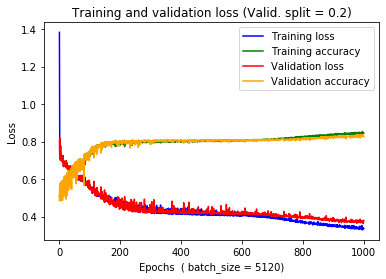

In [13]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [14]:
# use the model to predict whether an event is signal or background
y_test_pred = pd.DataFrame( model.predict( X_test.values  ) , index = X_test.index)

# as a comparison, use a mll based discriminator:
y_test_pred_mll = (1-abs(X_myTest[['mll']]-91.2)/91.2).values.flatten()

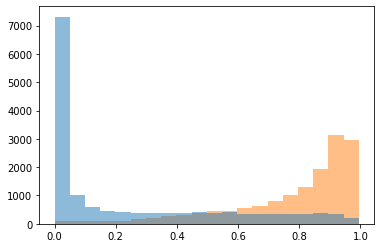

In [15]:
xbin = 20
hist, bins, ax = plt.hist( [ y_test_pred[y_test==0].values, y_test_pred[y_test==1].values ], xbin, log=False, label=['Background ('+ str((y_test==0).sum()) +')' ,'Signal ('+ str((y_test==1).sum()) +')'], histtype='stepfilled', alpha=0.5) 

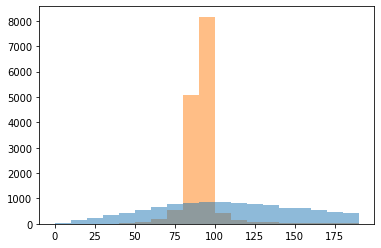

In [16]:
# just looking at M(ll)

xbin = range(0,200,10)
hist, bins, ax = plt.hist( [ X_myTest[['mll']][y_test==0].values, X_myTest[['mll']][y_test==1].values ], xbin, log=False, histtype='stepfilled', alpha=0.5) 

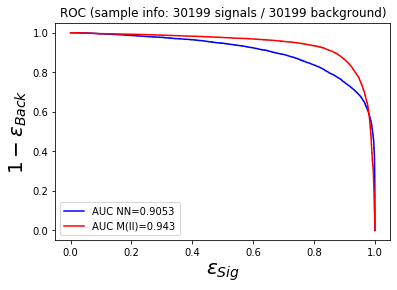

In [17]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'AUC NN=' + str(round(auc_val_test,4) ))

fpr_test_alt, tpr_test_alt, thresholds_test_alt = roc_curve( y_test, y_test_pred_mll )
auc_val_test_alt = auc(fpr_test_alt, tpr_test_alt)

plt.plot( tpr_test_alt, 1-fpr_test_alt, 'b', label= 'AUC M(ll)=' + str(round(auc_val_test_alt,4) ), color='red')

plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')


Some observations:
- with small data set, the performance deterioates pretty quickly when the network becomes too complicated
- without using the lepton charge, the NN underperforms wrt M(ll), but gets quite close once the hyper parameters are (roughly) optimized
- overtraining seems to be not a big problem, and one can use a large number of epochs
- we still use a small data set
- maybe a different model is better suited for our problem?



# Using some physics knowledge (4 vectors)

We can try to use a network that knows about 4 vectors.

This is WIP!


In [18]:
from lbn import LBN, LBNLayer

In [19]:
def convertTo4Vec( df ):

    eventSelection = ( (df['nLepton']==2) & (df['nVetoLepton']==2) )
        
    leptons = JaggedCandidateArray.candidatesfromcounts(
        df['nLepton'],
        pt=df['Lepton_pt'],
        eta=df['Lepton_eta'],
        phi=df['Lepton_phi'],
        mass= df['Lepton_mass'],
        charge=df['Lepton_pdgId']/abs(df['Lepton_pdgId'])
    )
    
    leptons = leptons[eventSelection]
    
    dileptons = leptons.choose(2)
    
    #dileptons.i0.p4.energy # gives the energy
    
    leading = np.array(list(zip(dileptons.i0.p4.energy.flatten(), dileptons.i0.p4.x.flatten(),dileptons.i0.p4.y.flatten(),dileptons.i0.p4.z.flatten())))
    subleading = np.array(list(zip(dileptons.i1.p4.energy.flatten(), dileptons.i1.p4.x.flatten(),dileptons.i1.p4.y.flatten(),dileptons.i1.p4.z.flatten())))

    leps = np.array(list(zip(leading,subleading)))
    
    return leps # not yet sure how to do this. have to zip?

In [46]:
bkg = LazyDataFrame(bkg_tree, flatten=True)
sig = LazyDataFrame(sig_tree, flatten=True)


inputs_sig = convertTo4Vec( sig )
inputs_bkg = convertTo4Vec( bkg )

nSignal = len(inputs_sig)

# training
inputs_sig_train = inputs_sig[:int(nSignal/2)]
inputs_bkg_train = inputs_bkg[:int(nSignal/2)]

inputs = np.concatenate((inputs_sig_train,inputs_bkg_train))

# test
inputs_sig_test = inputs_sig[int(nSignal/2):nSignal]
inputs_bkg_test = inputs_bkg[int(nSignal/2):nSignal]

inputs_test = np.concatenate((inputs_sig_test,inputs_bkg_test))


# training
y_sig = np.ones(len(inputs_sig_train))
y_bkg = np.zeros(len(inputs_bkg_train))
y_tmp = np.concatenate((y_sig,y_bkg))

# test
y_sig_test = np.ones(len(inputs_sig_test))
y_bkg_test = np.zeros(len(inputs_bkg_test))
y_test = np.concatenate((y_sig_test,y_bkg_test))

print (np.shape(inputs))
print (np.shape(y_tmp))

(30198, 2, 4)
(30198,)


In [79]:
# start a sequential model
model = tf.keras.models.Sequential()

# add the LBN layer
lbn_layer = LBNLayer((2, 4), n_particles=2, boost_mode=LBN.PAIRS, features=["E", "px", "py", "pz"])

model.add(lbn_layer)

model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=64, activation='relu' ) )
model.add( tf.keras.layers.Dense(units=8, activation='relu' ) )

model.add( tf.keras.layers.Dense(units=1, activation='sigmoid' ) ) 

# compile the model
model.compile( loss='binary_crossentropy', optimizer='rmsprop', metrics=['acc'])

#model.compile(loss="categorical_crossentropy")

features = model.predict(inputs)

In [80]:

history = model.fit(inputs, y_tmp, epochs=1000, batch_size=batch_size, validation_split=validation_split)

Epoch 1/1000
5/5 [==============================] - 0s 47ms/step - loss: 0.8330 - acc: 0.5483 - val_loss: 0.5632 - val_acc: 0.5369
Epoch 2/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6667 - acc: 0.6246 - val_loss: 0.6755 - val_acc: 0.4520
Epoch 3/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6610 - acc: 0.6341 - val_loss: 0.6036 - val_acc: 0.5515
Epoch 4/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6614 - acc: 0.6279 - val_loss: 0.7621 - val_acc: 0.3868
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6633 - acc: 0.6284 - val_loss: 0.8226 - val_acc: 0.3220
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6599 - acc: 0.6382 - val_loss: 0.6328 - val_acc: 0.5190
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6560 - acc: 0.6372 - val_loss: 0.8840 - val_acc: 0.2815
Epoch 8/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.6649 - a

5/5 [==============================] - 0s 13ms/step - loss: 0.5678 - acc: 0.7332 - val_loss: 0.9939 - val_acc: 0.2639
Epoch 64/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.5860 - acc: 0.7154 - val_loss: 0.5568 - val_acc: 0.5975
Epoch 65/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5701 - acc: 0.7332 - val_loss: 1.0874 - val_acc: 0.2325
Epoch 66/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.5786 - acc: 0.7278 - val_loss: 0.4919 - val_acc: 0.6707
Epoch 67/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.5761 - acc: 0.7259 - val_loss: 0.9351 - val_acc: 0.2947
Epoch 68/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5807 - acc: 0.7205 - val_loss: 0.5469 - val_acc: 0.6123
Epoch 69/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5640 - acc: 0.7412 - val_loss: 1.0431 - val_acc: 0.2435
Epoch 70/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5770 - acc: 0.

Epoch 125/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5116 - acc: 0.7889 - val_loss: 0.8756 - val_acc: 0.3695
Epoch 126/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5190 - acc: 0.7740 - val_loss: 0.5278 - val_acc: 0.6293
Epoch 127/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5193 - acc: 0.7816 - val_loss: 0.8463 - val_acc: 0.3916
Epoch 128/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5125 - acc: 0.7792 - val_loss: 0.5269 - val_acc: 0.6268
Epoch 129/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5181 - acc: 0.7830 - val_loss: 0.9395 - val_acc: 0.3333
Epoch 130/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5138 - acc: 0.7792 - val_loss: 0.6058 - val_acc: 0.5576
Epoch 131/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.5076 - acc: 0.7903 - val_loss: 0.9607 - val_acc: 0.3164
Epoch 132/1000
5/5 [==============================] - 0s 12ms/step - 

5/5 [==============================] - 0s 13ms/step - loss: 0.4698 - acc: 0.8035 - val_loss: 0.4885 - val_acc: 0.6520
Epoch 187/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4607 - acc: 0.8167 - val_loss: 0.7034 - val_acc: 0.5036
Epoch 188/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4413 - acc: 0.8145 - val_loss: 0.6165 - val_acc: 0.5740
Epoch 189/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4694 - acc: 0.8091 - val_loss: 0.8889 - val_acc: 0.4073
Epoch 190/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4574 - acc: 0.8093 - val_loss: 0.5675 - val_acc: 0.6083
Epoch 191/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4593 - acc: 0.8193 - val_loss: 0.8444 - val_acc: 0.4402
Epoch 192/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.4609 - acc: 0.8091 - val_loss: 0.5204 - val_acc: 0.6359
Epoch 193/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4469 - 

Epoch 248/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.4174 - acc: 0.8351 - val_loss: 0.4758 - val_acc: 0.6868
Epoch 249/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4212 - acc: 0.8433 - val_loss: 0.7019 - val_acc: 0.5540
Epoch 250/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4100 - acc: 0.8373 - val_loss: 0.4522 - val_acc: 0.7026
Epoch 251/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4211 - acc: 0.8435 - val_loss: 0.6452 - val_acc: 0.5866
Epoch 252/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4131 - acc: 0.8381 - val_loss: 0.4848 - val_acc: 0.6952
Epoch 253/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4135 - acc: 0.8443 - val_loss: 0.6458 - val_acc: 0.5932
Epoch 254/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4169 - acc: 0.8383 - val_loss: 0.4492 - val_acc: 0.7141
Epoch 255/1000
5/5 [==============================] - 0s 12ms/step - 

5/5 [==============================] - 0s 12ms/step - loss: 0.3871 - acc: 0.8504 - val_loss: 0.4237 - val_acc: 0.7326
Epoch 310/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3898 - acc: 0.8557 - val_loss: 0.6076 - val_acc: 0.6338
Epoch 311/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3820 - acc: 0.8520 - val_loss: 0.5406 - val_acc: 0.6791
Epoch 312/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3851 - acc: 0.8586 - val_loss: 0.8464 - val_acc: 0.5419
Epoch 313/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.4031 - acc: 0.8451 - val_loss: 0.4915 - val_acc: 0.7023
Epoch 314/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3693 - acc: 0.8574 - val_loss: 0.5633 - val_acc: 0.6619
Epoch 315/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3711 - acc: 0.8588 - val_loss: 0.7070 - val_acc: 0.5891
Epoch 316/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.4172 - 

Epoch 371/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3767 - acc: 0.8557 - val_loss: 0.4685 - val_acc: 0.7348
Epoch 372/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3808 - acc: 0.8650 - val_loss: 0.7194 - val_acc: 0.6194
Epoch 373/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3724 - acc: 0.8583 - val_loss: 0.4481 - val_acc: 0.7341
Epoch 374/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3727 - acc: 0.8632 - val_loss: 0.5596 - val_acc: 0.6743
Epoch 375/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3828 - acc: 0.8567 - val_loss: 0.4258 - val_acc: 0.7432
Epoch 376/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3625 - acc: 0.8669 - val_loss: 0.6171 - val_acc: 0.6530
Epoch 377/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3771 - acc: 0.8593 - val_loss: 0.4986 - val_acc: 0.7222
Epoch 378/1000
5/5 [==============================] - 0s 12ms/step - 

5/5 [==============================] - 0s 12ms/step - loss: 0.3603 - acc: 0.8673 - val_loss: 0.5641 - val_acc: 0.6815
Epoch 433/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3733 - acc: 0.8612 - val_loss: 0.4291 - val_acc: 0.7583
Epoch 434/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3640 - acc: 0.8690 - val_loss: 0.5530 - val_acc: 0.6901
Epoch 435/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3567 - acc: 0.8654 - val_loss: 0.4165 - val_acc: 0.7584
Epoch 436/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3692 - acc: 0.8683 - val_loss: 0.5957 - val_acc: 0.6712
Epoch 437/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3785 - acc: 0.8603 - val_loss: 0.4371 - val_acc: 0.7424
Epoch 438/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3469 - acc: 0.8697 - val_loss: 0.4432 - val_acc: 0.7485
Epoch 439/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3814 - 

Epoch 494/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3649 - acc: 0.8695 - val_loss: 0.6788 - val_acc: 0.6533
Epoch 495/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3566 - acc: 0.8649 - val_loss: 0.4145 - val_acc: 0.7654
Epoch 496/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3685 - acc: 0.8692 - val_loss: 0.5163 - val_acc: 0.7071
Epoch 497/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3665 - acc: 0.8644 - val_loss: 0.4569 - val_acc: 0.7490
Epoch 498/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3539 - acc: 0.8715 - val_loss: 0.5503 - val_acc: 0.6949
Epoch 499/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3660 - acc: 0.8671 - val_loss: 0.4337 - val_acc: 0.7608
Epoch 500/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3606 - acc: 0.8714 - val_loss: 0.6788 - val_acc: 0.6558
Epoch 501/1000
5/5 [==============================] - 0s 11ms/step - 

5/5 [==============================] - 0s 12ms/step - loss: 0.3563 - acc: 0.8684 - val_loss: 0.4606 - val_acc: 0.7575
Epoch 556/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3484 - acc: 0.8742 - val_loss: 0.5155 - val_acc: 0.7174
Epoch 557/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3600 - acc: 0.8678 - val_loss: 0.4123 - val_acc: 0.7725
Epoch 558/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3506 - acc: 0.8740 - val_loss: 0.5405 - val_acc: 0.7070
Epoch 559/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3597 - acc: 0.8682 - val_loss: 0.4725 - val_acc: 0.7497
Epoch 560/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3532 - acc: 0.8719 - val_loss: 0.6090 - val_acc: 0.6861
Epoch 561/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3638 - acc: 0.8675 - val_loss: 0.4638 - val_acc: 0.7500
Epoch 562/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3479 - 

Epoch 617/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3518 - acc: 0.8711 - val_loss: 0.4612 - val_acc: 0.7642
Epoch 618/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3475 - acc: 0.8745 - val_loss: 0.5155 - val_acc: 0.7224
Epoch 619/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3488 - acc: 0.8732 - val_loss: 0.4676 - val_acc: 0.7599
Epoch 620/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3604 - acc: 0.8729 - val_loss: 0.6526 - val_acc: 0.6800
Epoch 621/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3386 - acc: 0.8733 - val_loss: 0.4797 - val_acc: 0.7571
Epoch 622/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3503 - acc: 0.8738 - val_loss: 0.6045 - val_acc: 0.6897
Epoch 623/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3520 - acc: 0.8707 - val_loss: 0.4348 - val_acc: 0.7742
Epoch 624/1000
5/5 [==============================] - 0s 12ms/step - 

5/5 [==============================] - 0s 12ms/step - loss: 0.3388 - acc: 0.8780 - val_loss: 0.6311 - val_acc: 0.6922
Epoch 679/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3484 - acc: 0.8723 - val_loss: 0.4040 - val_acc: 0.7825
Epoch 680/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3397 - acc: 0.8776 - val_loss: 0.4849 - val_acc: 0.7387
Epoch 681/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3427 - acc: 0.8747 - val_loss: 0.4931 - val_acc: 0.7530
Epoch 682/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3358 - acc: 0.8781 - val_loss: 0.6264 - val_acc: 0.6934
Epoch 683/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3503 - acc: 0.8728 - val_loss: 0.4053 - val_acc: 0.7833
Epoch 684/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3370 - acc: 0.8795 - val_loss: 0.5606 - val_acc: 0.7154
Epoch 685/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3474 - 

Epoch 740/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3325 - acc: 0.8778 - val_loss: 0.4393 - val_acc: 0.7712
Epoch 741/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3284 - acc: 0.8798 - val_loss: 0.4082 - val_acc: 0.7930
Epoch 742/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3467 - acc: 0.8770 - val_loss: 0.5570 - val_acc: 0.7212
Epoch 743/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3341 - acc: 0.8790 - val_loss: 0.4765 - val_acc: 0.7712
Epoch 744/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3425 - acc: 0.8781 - val_loss: 0.5338 - val_acc: 0.7366
Epoch 745/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3232 - acc: 0.8804 - val_loss: 0.3765 - val_acc: 0.7969
Epoch 746/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3412 - acc: 0.8805 - val_loss: 0.7132 - val_acc: 0.6758
Epoch 747/1000
5/5 [==============================] - 0s 13ms/step - 

5/5 [==============================] - 0s 13ms/step - loss: 0.3321 - acc: 0.8805 - val_loss: 0.5820 - val_acc: 0.7215
Epoch 802/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3288 - acc: 0.8788 - val_loss: 0.4502 - val_acc: 0.7826
Epoch 803/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3306 - acc: 0.8807 - val_loss: 0.5672 - val_acc: 0.7253
Epoch 804/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3349 - acc: 0.8770 - val_loss: 0.4863 - val_acc: 0.7724
Epoch 805/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3250 - acc: 0.8828 - val_loss: 0.5102 - val_acc: 0.7589
Epoch 806/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.3179 - acc: 0.8830 - val_loss: 0.4319 - val_acc: 0.7825
Epoch 807/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3432 - acc: 0.8788 - val_loss: 0.5134 - val_acc: 0.7422
Epoch 808/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3290 - 

Epoch 863/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3313 - acc: 0.8786 - val_loss: 0.5427 - val_acc: 0.7621
Epoch 864/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3182 - acc: 0.8855 - val_loss: 0.5488 - val_acc: 0.7495
Epoch 865/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3247 - acc: 0.8811 - val_loss: 0.3812 - val_acc: 0.8066
Epoch 866/1000
5/5 [==============================] - 0s 15ms/step - loss: 0.3301 - acc: 0.8829 - val_loss: 0.5098 - val_acc: 0.7531
Epoch 867/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.3216 - acc: 0.8828 - val_loss: 0.4970 - val_acc: 0.7765
Epoch 868/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.3232 - acc: 0.8842 - val_loss: 0.6109 - val_acc: 0.7260
Epoch 869/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.3210 - acc: 0.8822 - val_loss: 0.5075 - val_acc: 0.7750
Epoch 870/1000
5/5 [==============================] - 0s 13ms/step - 

5/5 [==============================] - 0s 12ms/step - loss: 0.3100 - acc: 0.8874 - val_loss: 0.5226 - val_acc: 0.7571
Epoch 925/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3282 - acc: 0.8810 - val_loss: 0.4477 - val_acc: 0.7939
Epoch 926/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3097 - acc: 0.8859 - val_loss: 0.4841 - val_acc: 0.7700
Epoch 927/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3205 - acc: 0.8830 - val_loss: 0.3954 - val_acc: 0.8106
Epoch 928/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3171 - acc: 0.8853 - val_loss: 0.6082 - val_acc: 0.7296
Epoch 929/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3208 - acc: 0.8831 - val_loss: 0.3336 - val_acc: 0.8220
Epoch 930/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3172 - acc: 0.8853 - val_loss: 0.5048 - val_acc: 0.7611
Epoch 931/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3209 - 

Epoch 986/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.3076 - acc: 0.8868 - val_loss: 0.3373 - val_acc: 0.8220
Epoch 987/1000
5/5 [==============================] - 0s 11ms/step - loss: 0.3184 - acc: 0.8866 - val_loss: 0.6569 - val_acc: 0.7230
Epoch 988/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3145 - acc: 0.8841 - val_loss: 0.4056 - val_acc: 0.8061
Epoch 989/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3141 - acc: 0.8848 - val_loss: 0.5209 - val_acc: 0.7614
Epoch 990/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3132 - acc: 0.8841 - val_loss: 0.4037 - val_acc: 0.8101
Epoch 991/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3092 - acc: 0.8872 - val_loss: 0.5303 - val_acc: 0.7666
Epoch 992/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.3146 - acc: 0.8832 - val_loss: 0.4246 - val_acc: 0.8045
Epoch 993/1000
5/5 [==============================] - 0s 12ms/step - 

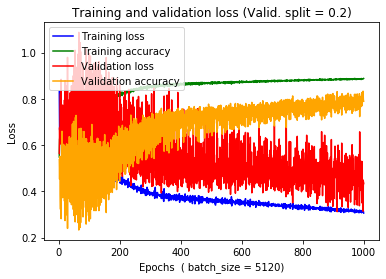

In [81]:
history_dict = history.history

loss_values  = history_dict['loss']
acc_values = history_dict['acc']

epochslist = range(1,  len(loss_values)+1)
        
plt.plot(epochslist, loss_values, 'b', label='Training loss')
plt.plot(epochslist, acc_values,'b', color='green', label='Training accuracy')
try:
    val_loss_values = history_dict['val_loss']
    plt.plot(epochslist, val_loss_values, 'b', color='red', label='Validation loss')
    val_acc_values = history_dict['val_acc']
    plt.plot(epochslist, val_acc_values, 'b', color='orange', label='Validation accuracy')
except KeyError:
    print ("Didn't find validation loss")

plt.title('Training and validation loss (Valid. split = ' + str( validation_split ) + ')')
plt.xlabel('Epochs  ( batch_size = ' + str( batch_size ) + ')')
plt.ylabel('Loss')
plt.legend()

In [82]:
y_test_pred = pd.DataFrame( model.predict( inputs_test  ) )

In [84]:
fpr_test, tpr_test, thresholds_test = roc_curve( y_test, y_test_pred )

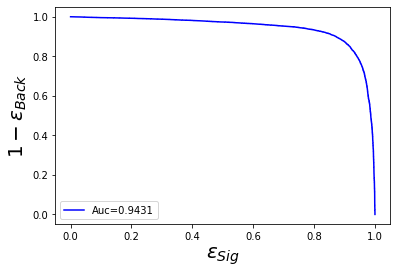

In [85]:
auc_val_test = auc(fpr_test, tpr_test)

plt.plot( tpr_test, 1-fpr_test, 'b', label= 'Auc=' + str(round(auc_val_test,4) ))

#plt.title('ROC (sample info: ' + str( len( X_test[y_test == 1] ) + len( X_train[y_train == 1] ) ) + ' signals / '
#                                              + str( len( X_test[y_test == 0] ) + len( X_train[y_train == 0] ) ) + ' background)'  )
plt.xlabel('$\epsilon_{Sig}$', fontsize = 20) # 'False positive rate'
plt.ylabel('$1-\epsilon_{Back}$', fontsize = 20) #  '1-True positive rate' 
plt.legend(loc ='lower left')